## In this notebook, we create a simple month conditioned flood diffusion model

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2

import rasterio
from rasterio.enums import Resampling
from natsort import natsorted
from tqdm import tqdm
import os
from pathlib import Path
import re
from datetime import datetime

def imshow_normalized(tensor_img, mean = (0.5, ), std = (0.5, )):
    """
    Function that displays a normalized tensor image using matplotlib.
    
    """
    assert tensor_img.dim() == 3, "Input tensor must be 3-dimensional (C, H, W)"
    img = tensor_img.clone().cpu().numpy()
    assert len(mean) == img.shape[0] and len(std) == img.shape[0], "Mean and std must match number of channels"
    for c in range(img.shape[0]):
        img[c] = img[c] * std[c] + mean[c]  # Unnormalize

    # Transpose to H, W, C
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.axis('off')


In [69]:
class FloodDataset(Dataset):
    def __init__(self, root_dir, target_size = (1024, 1024), transform = None):
        self.root_dir = Path(root_dir)
        self.target_size = target_size
        self.transform = transform

        image_paths = natsorted(list(self.root_dir.rglob('*.tif')))
        if not image_paths:
            raise ValueError(f"No .tif files found in {root_dir}")
        
        self.path_month = []

        for p in image_paths:
            try:
                month = self._infer_month_from_path(p)
                self.path_month.append((p, month))
            except ValueError as e:
                print(f"Skipping {p.name}: {e}")

        # self.months = [self._infer_month_from_path(p) for p in self.image_paths]
        
    def __len__(self):
        return len(self.path_month)
    
    def __getitem__(self, idx):
        # Obtain image path and corresponding month
        img_path, month = self.path_month[idx]
        # month = int(self._infer_month_from_path(img_path))

        # Resample image to target size
        arr = self._resample(img_path)
      
        # Arr is currently uint8 values, 0, 1, 2
        mask = np.where(arr == 2, 1, 0).astype(np.uint8)
        # mask = mask[None, :, :]  # 1, H, W
        mask = torch.from_numpy(mask).to(torch.float32).unsqueeze(0)  # 1, H, W
        arr = None

        if self.transform:
            mask = self.transform(mask)

        meta = {
            "path": str(img_path),
            "month": month
        }

        return mask, int(month - 1), meta

    
    def _resample(self, p: Path) -> np.ndarray:
        """
        Use rasterio to resample the first band to target size.
        """
        with rasterio.open(p) as src:
            arr = src.read(
                1,
                out_shape = self.target_size,
                resampling = Resampling.nearest # Since these are binary flood maps
            )

        return arr.astype(np.uint8)

    @staticmethod
    def _infer_month_from_path(path):
        filename = path.stem

        match = re.match(r'^(\d{4}-\d{2})', filename)
        if match:
            year_month = match.group(1)
            year_month = datetime.strptime(year_month, "%Y-%m")
            return year_month.month
        else:
            raise ValueError(f"Filename {filename} does not match expected pattern 'YYYY-MM...'.")
            # print(f"Pattern not found in filename: {filename}. Defaulting to None.")
            # return None

In [76]:
# Define data directory
data_dir = Path("flood_data/monthly_flood_maps")
BATCH_SIZE = 8 

# Define transforms
transform = v2.Compose([
    # Convert to float32 tensor: used if input is numpy array
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = False),

    # Apply random horizontal flip
    v2.RandomHorizontalFlip(p = 0.5),
    # Apply normalization to center data around 0, this will scale values to [-1, 1]
    v2.Normalize(mean = [0.5], std = [0.5])
])

    
# Create dataset
flood_dataset = FloodDataset(data_dir, target_size = (1024, 1024), transform = transform)

# Define data loader
flood_dataloader = DataLoader(
    dataset = flood_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 4,
)

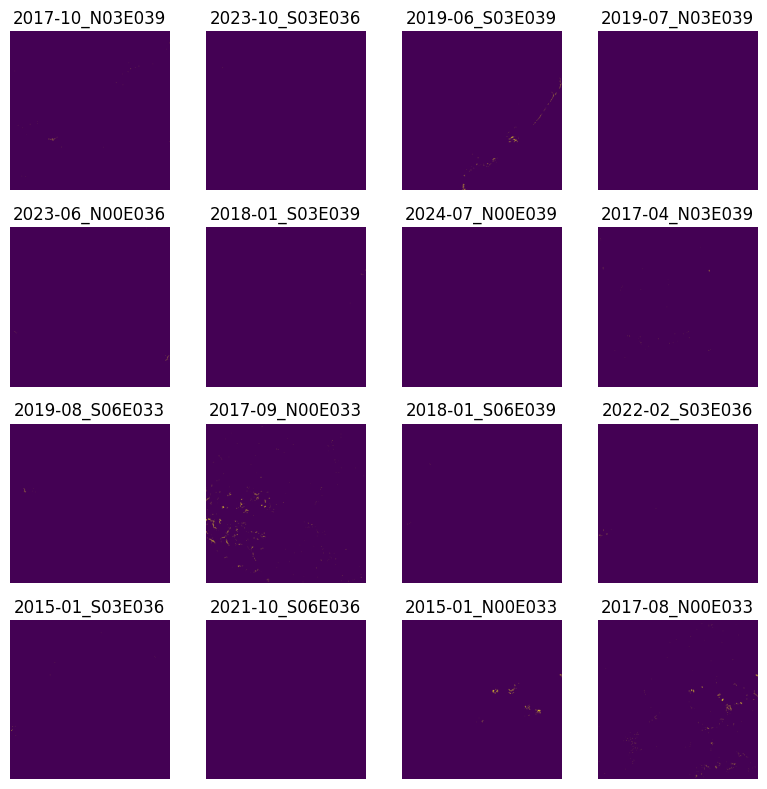

In [ ]:
plt.figure(figsize = (10, 10))
rows, cols = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randperm(len(flood_dataset))[0]
    # Get a sample
    sample = flood_dataset[sample_idx]
    img, label, meta = sample
    plt.subplot(rows, cols, i)
    imshow_normalized(img)
    plt.title(f"{Path(meta['path']).stem.split('_flood_map')[0]}")

plt.tight_layout()
plt.savefig("flood_samples.png", dpi = 1000)

In [82]:
Path(meta['path']).stem.split("_flood_map")[0]

'2023-10_N03E033'

In [ ]:
plt.figure(figsize = (6, 6))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = random.randint(0, len(train_set) - 1)
    img, label = train_set[sample_idx]
    plt.subplot(rows, cols, i)
    imshow_normalized(img)
    plt.title(f"Label: {label}")
plt.tight_layout()
plt.show()

In [71]:
list(range(1, cols * rows + 1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [ ]:
a = torch.randn(2, 3, 2, 2)
b = torch.zeros(1, 3, )

In [ ]:
def imshow_normalized(tensor_img):
    img = tensor_img.clone().cpu().numpy()
    img = img * mnist_std + mnist_mean  # Unnormalize
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')

In [59]:
flood_dataset[9][0].min(), flood_dataset[9][0].max(), flood_dataset[9][0].shape, flood_dataset[9][0].dtype

(tensor(-1.), tensor(1.), torch.Size([1, 1024, 1024]), torch.float32)

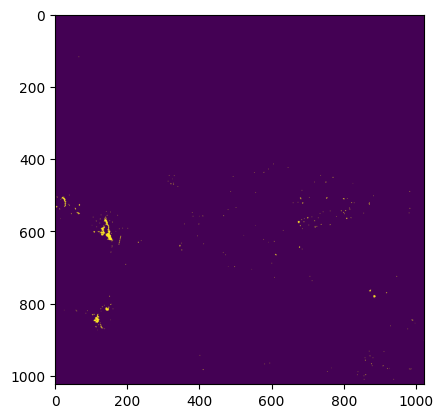

In [55]:
import matplotlib.pyplot as plt
plt.imshow(flood_dataset[9][0][0])

In [13]:
from torchvision.transforms.v2 import ToDtype
t = torch.tensor([[0, 1, 2]], dtype=torch.uint8)   # values 0..255 domain
ToDtype(torch.float32, scale=False)(t)
# -> tensor([[0., 1., 2.]], dtype=torch.float32)   # same numeric values, now float


tensor([[0., 1., 2.]])

In [8]:

ToDtype(torch.float32, scale=True)(t)
# -> tensor([[0.0, 1/255, 2/255]], dtype=torch.float32)  # scaled to [0,1]


tensor([[0.0000, 0.0039, 0.0078]])

In [ ]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
out = transforms(img)

plot([img, out])

In [ ]:
a = torch.randn(1, 1, 32, 32)
torch.mean(a, dim = 1)

tensor([-0.0226])

In [6]:
torch.mean(a, dim = 1)

tensor([[[ 0.3386, -0.8892, -0.9999,  ..., -1.8014, -0.7231, -1.0987],
         [ 0.2201, -0.3442,  0.3111,  ...,  0.2998, -1.2791, -1.1061],
         [ 0.2172, -0.5049,  0.7490,  ..., -1.1005, -0.7943, -0.8499],
         ...,
         [ 0.7388, -1.5913, -3.4929,  ..., -0.8005,  0.7236,  0.2638],
         [ 1.5274, -0.6742, -0.8840,  ..., -1.4996, -1.4067, -1.8768],
         [-0.7951,  0.1930,  0.6902,  ...,  0.5593,  2.3189, -0.2942]]])

In [7]:
flood_dataset[100][0].min(), flood_dataset[100][0].max()

(tensor(0.), tensor(0.0039))

In [26]:
a = np.random.randint(0, 2, size=(5, 5), dtype=np.uint8)
torch.from_numpy(a).dtype

torch.uint8

In [8]:
data_dir = Path("flood_data/monthly_flood_maps")
assert data_dir.exists(), f"Data directory {data_dir} does not exist"
image_paths = natsorted(list(data_dir.rglob('*.tif')))
len(image_paths)

1440

In [15]:
def _infer_month_from_path(path):
    filename = path.stem

    match = re.match(r'^(\d{4}-\d{2})', filename)
    if match:
        year_month = match.group(1)
        year_month = datetime.strptime(year_month, "%Y-%m")
        return year_month.month
    else:
        print(f"Pattern not found in filename: {filename}. Defaulting to None.")
        return None
    
_infer_month_from_path(image_paths[100])
    

9

In [9]:
image_paths[100]

WindowsPath('flood_data/monthly_flood_maps/2015/2015-09_N03E036_flood_map.tif')

In [12]:
with rasterio.open(image_paths[100]) as src:
    arr = src.read(
        1,
        out_shape = (1024, 1024),
        resampling = Resampling.nearest # Since these are binary flood maps
    )

arr = np.where(arr == 2, 1, 0).astype(np.uint8)
arr.max(), arr.min()
    

(np.uint8(1), np.uint8(0))

In [16]:
# Convert to tensor
transforms.ToTensor()(torch.from_numpy(arr)).min(), transforms.ToTensor()(torch.from_numpy(arr)).max()

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [ ]:
# Convert to tensor


In [15]:
1/255

0.00392156862745098

In [11]:
arr, arr.dtype

(array([[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0]], shape=(1024, 1024), dtype=uint8),
 dtype('uint8'))

In [9]:
image_paths[0].stem

'2015-01_N00E033_flood_map'

In [ ]:

class FloodDataset(Dataset):
    def __init__(self, root_dir, target_size=(1024, 1024), month_mapping=None):
        """
        Args:
            root_dir (str or Path): Directory containing your flood GeoTIFF files.
                                    Assumes filenames or folder structure can provide month info.
                                    e.g., 'data/flood_2020_01_event.tif' where '01' is January.
            target_size (tuple): Target (height, width) for resizing flood maps.
            month_mapping (dict, optional): A dictionary mapping month numbers (e.g., 1-12)
                                             to model input (e.g., embedding indices or one-hot).
                                             If None, raw month number (0-11 for 0-indexed) will be used.
        """
        self.root_dir = Path(root_dir)
        self.target_size = target_size
        self.month_mapping = month_mapping if month_mapping is not None else {i+1: i for i in range(12)} # Default 1-12 to 0-11

        self.image_paths = natsorted(list(self.root_dir.glob('*.tif')))
        if not self.image_paths:
            raise FileNotFoundError(f"No GeoTIFFs found in {self.root_dir}")

        print(f"Found {len(self.image_paths)} flood maps.")

    def _extract_month_from_path(self, file_path):
        """
        Placeholder for month extraction logic.
        You'll need to customize this based on your actual file naming convention.
        Example: 'flood_event_2023_04_01.tif' -> month '04' -> 4
        """
        # --- CUSTOMIZE THIS SECTION ---
        # Example 1: Month is the 4th element (index 3) in a '_' separated filename part
        # try:
        #     month_str = file_path.stem.split('_')[3]
        #     month = int(month_str)
        #     return month
        # except (IndexError, ValueError):
        #     print(f"Warning: Could not extract month from {file_path.name}. Defaulting to 1 (January).")
        #     return 1

        # Example 2: Month is in a parent directory name (e.g., 'data/04/event.tif')
        # try:
        #     month = int(file_path.parent.name)
        #     return month
        # except (ValueError):
        #     print(f"Warning: Could not extract month from parent dir of {file_path.name}. Defaulting to 1.")
        #     return 1

        # Example 3: Month is hardcoded for a simplified test (NOT for production)
        # return 7 # Always July for all images

        # Default fallback (you should replace this with actual logic)
        return 1 # Fallback to January if no clear logic is implemented
        # --- END CUSTOMIZATION ---


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        # 1. Extract Month
        raw_month = self._extract_month_from_path(img_path)
        month_tensor = torch.tensor(self.month_mapping.get(raw_month, 0), dtype=torch.long) # Use .get() with default for robustness

        # 2. Load and Process Flood Map
        with rasterio.open(img_path) as src:
            # Read the flood label band (assuming it's the first band or a specific band)
            # You might need to adjust `src.read(1)` if your labels are in a different band.
            flood_map_raw = src.read(1)

            # Filter for label == 2 (flooded areas)
            # Create a binary mask: 1 where label is 2, 0 otherwise
            binary_flood_map = (flood_map_raw == 2).astype(np.float32) # Ensure float32 for PyTorch

            # Resize/Resample the binary flood map
            # Use nearest-neighbor for binary data to avoid interpolation artifacts
            flood_map_resized = np.empty(self.target_size, dtype=np.float32)
            rasterio.warp.reproject(
                source=binary_flood_map,
                destination=flood_map_resized,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=rasterio.transform.from_bounds(
                    src.bounds.left, src.bounds.bottom, src.bounds.right, src.bounds.top,
                    self.target_size[1], self.target_size[0] # width, height
                ),
                dst_crs=src.crs, # Keep same CRS for simplicity in this step
                resampling=Resampling.nearest,
                num_threads=os.cpu_count() // 2 if os.cpu_count() else 1
            )
            # Ensure the output is still binary after resampling if necessary
            flood_map_resized = (flood_map_resized > 0.5).astype(np.float32)

            # Add channel dimension (C, H, W). For binary, C=1.
            flood_map_tensor = torch.from_numpy(flood_map_resized).unsqueeze(0)

        return flood_map_tensor, month_tensor

# --- Example Usage ---
if __name__ == "__main__":
    # 1. Create a dummy data directory and some dummy GeoTIFFs for testing
    dummy_data_dir = Path("./dummy_flood_data")
    dummy_data_dir.mkdir(exist_ok=True)

    # Create dummy GeoTIFFs for months 1, 2, 3
    print("Creating dummy GeoTIFF files...")
    for i in tqdm(range(1, 10)): # 9 dummy files
        month = (i % 3) + 1 # Cycle through months 1, 2, 3
        dummy_file_path = dummy_data_dir / f"flood_event_2023_{month:02d}_{i:02d}.tif"
        width, height = 18000, 18000
        profile = {
            'driver': 'GTiff',
            'height': height,
            'width': width,
            'count': 1,
            'dtype': rasterio.uint8,
            'crs': 'EPSG:4326',
            'transform': rasterio.transform.from_bounds(0, 0, 10, 10, width, height)
        }
        with rasterio.open(dummy_file_path, 'w', **profile) as dst:
            # Create a simple "flood" pattern: label 2 in a random square
            data = np.zeros((height, width), dtype=np.uint8)
            start_x, start_y = np.random.randint(0, width - 1000), np.random.randint(0, height - 1000)
            data[start_y:start_y+1000, start_x:start_x+1000] = 2 # Flood label
            dst.write(data, 1)

    print("Dummy GeoTIFFs created. Initializing dataset...")

    # 2. Initialize the Dataset
    # You'll need to customize the month extraction logic in the Dataset class
    # to match your actual file naming convention.
    try:
        # Example: Month is the 4th element (index 3) in a '_' separated filename part
        # We need to make a small adjustment to _extract_month_from_path in the class
        # to correctly parse the dummy filenames.
        # For this example, let's temporarily modify the class directly or make a derived one.
        class TestFloodDataset(FloodDataset):
            def _extract_month_from_path(self, file_path):
                try:
                    month_str = file_path.stem.split('_')[3]
                    month = int(month_str)
                    return month
                except (IndexError, ValueError):
                    print(f"Warning: Could not extract month from {file_path.name}. Defaulting to 1 (January).")
                    return 1

        flood_dataset = TestFloodDataset(root_dir=dummy_data_dir, target_size=(1024, 1024))
    except FileNotFoundError as e:
        print(e)
        print("Please ensure your `dummy_flood_data` directory exists and contains GeoTIFFs.")
        exit()

    # 3. Initialize the DataLoader
    batch_size = 4
    num_workers = 0 # Set to 0 for debugging, increase for performance in training
    flood_dataloader = DataLoader(flood_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    # 4. Test retrieving a batch
    print(f"\nTesting DataLoader with batch size {batch_size}...")
    for i, (flood_maps, months) in enumerate(flood_dataloader):
        print(f"Batch {i+1}:")
        print(f"  Flood Maps Batch Shape: {flood_maps.shape} (Expected: B, 1, H, W)")
        print(f"  Months Batch Shape: {months.shape} (Expected: B)")
        print(f"  Sample Flood Map (first in batch) min/max: {flood_maps[0].min().item()}/{flood_maps[0].max().item()}")
        print(f"  Sample Months (first in batch): {months[0].item()}")

        # Visualize one of the resized flood maps
        if i == 0:
            print("Displaying a sample resized flood map (first in batch)...")
            plt.figure(figsize=(6, 6))
            plt.imshow(flood_maps[0].squeeze().cpu().numpy(), cmap='gray')
            plt.title(f"Sample Resized Flood Map (Month Index: {months[0].item()})")
            plt.colorbar(label='Flood (1) / No Flood (0)')
            plt.show()

        if i == 2: # Stop after a few batches for demonstration
            break

    print("\nDataLoader test complete.")
    # Optional: Clean up dummy data
    # import shutil
    # shutil.rmtree(dummy_data_dir)
    # print(f"Cleaned up dummy data directory: {dummy_data_dir}")

In [ ]:
# requirements: pip install rasterio torch torchvision polars geopandas
import os
from pathlib import Path
from typing import List, Optional, Tuple
import random

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
import rasterio
from rasterio.enums import Resampling


class FloodMaskDataset(Dataset):
    """
    Dataset that:
      - takes a list of monthly GeoTIFF file paths (each file is a single-month mask)
      - resamples each file on-the-fly to target_size (H,W) using nearest resampling
      - converts to binary mask: 1 where raster_value == 2, else 0
      - returns (mask_tensor, month_index, metadata)
    Args:
      files: list of Path or str for GeoTIFFs. Filenames should contain year/month or you supply months list separately.
      months: optional list[int] same length as files giving month index (1..12). If not supplied we try to parse from filename.
      target_size: (H, W) e.g. (1024, 1024)
      cache_dir: optional Path to store cached resized npy masks (speeds up multiple epochs)
      dtype: output torch dtype (torch.float32)
    """
    def __init__(self,
                 files: List[Path],
                 months: Optional[List[int]] = None,
                 target_size: Tuple[int,int] = (1024,1024),
                 cache_dir: Optional[Path] = None,
                 preload_cache: bool = False):
        self.files = [Path(f) for f in files]
        if months is None:
            self.months = [self._infer_month_from_path(p) for p in self.files]
        else:
            assert len(months) == len(files)
            self.months = months
        self.H, self.W = target_size
        self.cache_dir = Path(cache_dir) if cache_dir is not None else None
        if self.cache_dir:
            self.cache_dir.mkdir(parents=True, exist_ok=True)
        self.preload_cache = preload_cache

        # Optionally pre-generate caches
        if self.preload_cache and self.cache_dir is not None:
            for i, p in enumerate(self.files):
                _ = self._get_cached_path(p)
                if not Path(_) .exists():
                    # force creation
                    self._resample_and_cache(p, cached_path=_)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        p = self.files[idx]
        month = int(self.months[idx])  # 1..12
        # try cache
        if self.cache_dir is not None:
            cache_path = self._get_cached_path(p)
            if cache_path.exists():
                arr = np.load(cache_path)   # uint8 array shape (H,W)
            else:
                arr = self._resample_and_cache(p, cached_path=cache_path)
        else:
            arr = self._resample(p)

        # arr currently is uint8 values e.g., 0,1,2. Convert to binary mask where 2 -> 1
        mask = (arr == 2).astype(np.uint8)  # shape (H,W) values 0/1

        # Convert to float32 tensor scaled to [-1,1] or [0,1] per your diffusion pipeline.
        # Many diffusion implementations expect images in [-1,1]. For binary mask we keep [0,1].
        mask_t = torch.from_numpy(mask).to(torch.float32).unsqueeze(0)  # (1,H,W)

        # metadata optionally
        meta = {
            "path": str(p),
            "month": month
        }
        return mask_t, int(month - 1), meta  # month-1 -> 0..11 for embedding indices

    def _get_cached_path(self, p: Path) -> Path:
        # cache file name derived from original filename
        name = p.stem + f"_{self.H}x{self.W}.npy"
        return self.cache_dir / name

    def _resample_and_cache(self, p: Path, cached_path: Path):
        arr = self._resample(p)
        np.save(cached_path, arr)
        return arr

    def _resample(self, p: Path) -> np.ndarray:
        """
        Use rasterio to resample the first band to (H,W) with nearest neighbor.
        Returns numpy array dtype=uint8
        """
        with rasterio.open(p) as src:
            # out_shape expects (bands, out_h, out_w) if reading bands, but we read single band
            out_shape = (1, self.H, self.W)
            data = src.read(1, out_shape=out_shape, resampling=Resampling.nearest)
            # data shape is (out_h, out_w) after selection by read
            # ensure uint8
            return data.astype(np.uint8)

    @staticmethod
    def _infer_month_from_path(p: Path) -> int:
        """
        Try to infer month from filename patterns like ..._2024-03_... or ...202403...
        Fallback random month (not ideal) — warn user.
        """
        s = p.stem
        import re
        m = re.search(r"(\d{4})[-_](\d{2})", s) or re.search(r"(\d{4})(\d{2})", s)
        if m:
            month = int(m.group(2))
            if 1 <= month <= 12:
                return month
        # fallback: try month token like _03_
        m2 = re.search(r"[_\-](\d{2})[_\-]", s)
        if m2:
            mm = int(m2.group(1))
            if 1 <= mm <= 12:
                return mm
        # final fallback: assign 1 and warn
        # print warning once
        # (better: require months list)
        return 1
